# A Beginner's Friendly Introduction to Diffusion Models in JAX

**Axel Donath** | PyData Meeting Boston JUne 18th, 2025 


**Who Am I?**
I am a Postdoctoral Researcher at the Center for Astrophysics | Harvard & Smithsonian where I research in the field X-Ray and Gamma-Ray Astronomy. I develop new AI, machine learning and statistical methods as well as scientific open source software for the analysis of astronomical low counts data. I'm also editor for the Astronomy and Astrophysics track of the Journal of Open Source Software [JOSS](https://joss.theoj.org).

You can find out more about me and my work at:

- https://axeldonath.com
- https://github.com/adonath


This tutorial notebook is a beginner's friendly introduction to diffusion models in JAX. It is mostly focused on introducing the core concepts of [diffusion models](https://en.wikipedia.org/wiki/Diffusion_model) from first principles along with teaching the basics of [JAX](https://docs.jax.dev/en/latest/), a differentiable, GPU accelerated, array library for deep learning and scientific computing.


## Prerequisites 

- \>2 years of experience with Python, [Numpy](https://numpy.org) and [Matplotlib](https://matplotlib.org)
    - Python standard library, functools, namedtuple
    - array operations, random number sampling, 1d/2d plotting, histograms
- Undergraduate level knowledge of ML, probability, statistics and linear algebra
    - Probability density functions, definitions of variance and mean
    - Multivariate Gaussian distributions
    - Maximum Likelihood Estimation
    - (Stochastic) Gradient descent
    - Multilayer Perceptron
- No prior knowledge of Diffusion Models nor JAX is required!


## What are Diffusion Models?
Diffusion models are a class of generative models that are based on the concept of iteratively removing noise from an image
or other data. "Generative" means they model a probability distribution and can be used to draw new samples from the distribution and thus generate new plausible images. Or an alternative way of thinking about diffusion models is to think of them as sampling algorithms, that sample from a fixed distribution. Where the distribution we sample from is defined by the distribution of the data we use for training them. 

![images/sde_schematic.jpg]

However sampling from high dimensional distributions, such as the distribution of natural images, where each pixel is treated as an independent dimension, can be technically quite challenging. Diffusion models are a way to make this sampling process feasible and scalable. Diffusion model are mathematically well founded and draw many parallels to actual physical diffusion processes, 
denoising methods in image processing as well as theory of (stochastic) differential equations.

In this tutorial We will take a look at a specific type of diffusion models called Denoising Diffusion Probabilistic Models (DDPMs) introduced by [Ho et al. in 2020.](https://arxiv.org/abs/2006.11239). We will start with simple "toy examples" on 1d and 2d data to illustrate the method and then proceed to a more realistic case of actually sampling images. 

**Note**: I personally find that "diffusion models" are to a certain degree a misnomer, as the relevant part of the model is the reverse process, where the diffuson process is inverted. But we will learn about that later.

## What is JAX?
In a single sentence you can think of JAX as Numpy with support for GPUs and automatic differentiation.
It also includes a just in time compilation (JIT) and function transforms, such as vectorization (np.vectorize)
which is automatically lowered to hardware accelerated XLA instructions (StableHLO).

TBD...


## More Ressources 

An excellent intuitive introduction to the math behind diffusion models can be found in the following video series by
[Deepia](https://www.youtube.com/@Deepia-ls2fo) on Youtube:

- Denoising Autoencoders: https://youtu.be/0V96wE7lY4w?si=h82tsQOYRc7-Vwly
- Langevin Algorithm: https://youtu.be/m0OTso2Dc2U?si=_Yld6zr2jkQEGuuI
- Diffusion Models: https://youtu.be/EhndHhIvWWw?si=e_s1A9dyOF7NLCsg

If you would like to prepare for this tutorial I would recommend to watch those videos in advance. They are each 15-30 minutes long and watching them in the given order is recommended.

If you are interested in more details and different perspectives about diffusion models 
I recommend to checkout the following blog posts:

- Key read: https://yang-song.net/blog/2021/score/
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#nice


Other minimal implementations in PyTorch:

- https://github.com/joseph-nagel/diffusion-demo/blob/main/notebooks/swissroll.ipynb
- https://github.com/acids-ircam/diffusion_models/ 


## Glossary
- **Score Function**: the score function of a distribution is the gradient of the log-density function with respect to the input
- **Reverse Process**: the reverse process is the process of removing noise from an image / data
- **Forward Process**: the forward process is the process of adding noise to an image / data
- **Sample / Particle**: a sample from a n-dimensional distribution is a n-dimensional vector / point described by its coordinates, a specific realisation (or measurment) of a random variable
- **Distribution / Probability Density Function / Likelihood**: a functional or numerical form describing the probabilitty density of a random variable. 


## Warm Up: the Diffusion Process

Diffusion is typically a physical process where particles spread from regions of high concentration to regions of low concentration over time, driven by random motion. In nature, this can be seen in phenomena like the dispersal of ink in water or the flow of heat through a solid. Mathematically, diffusion is often modeled using stochastic processes or differential equations, capturing how randomness leads to gradual smoothing and homogenization of an initial state. In a more genral understanding diffusion can also include convection, meaning a systematic drift of the particles driven by an external force, such as wind, or stiring in a mixing process. 

We will first explore the process of diffusion on a simple example in JAX. Let's start with the relevant imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
import jax
from functools import partial
from jax import random
from collections import namedtuple
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

from sklearn.datasets import make_swiss_roll
import numpy as np
from utils import animate_trajectory, plot_vector_field
from collections import namedtuple
from functools import partial

import equinox as eqx
import optax

The `jax.numpy` namespace can be thought of as a "drop-in" replacemnt for numpy. It was designed to be as similar as possible to the standard `numpy` namespace. In almost all cases you will find the equivalent of some `np.<>` function in `jnp.<>`. Howevere there is one important difference: **array objects in JAX are not mutable**, meaning they cannot be modified in place. Something like `array[2:3] = 3`, **does not work** in JAX, for reasons that become clear later, when we dicuss just in time compilation (JIT). There is a handful  more of these differences which are documented in ["JAX - The Sharp Bits"](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html).

For this illustrative example we will work with a simple mixture of Gaussians as the inital distribution of the "particles" (I will use "particles" and "samples" synonymously). In JAX we can just use functionality in the `jnp.<>` namespace to define our model:

In [3]:
def gaussian(x, norm, mu, sigma):
    """Single Gaussian distribution"""
    return norm * jnp.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * jnp.sqrt(2 * np.pi))


def gmm(x, norm, mu, sigma):
    """Gaussian Mixture Model"""
    values = jnp.sum(gaussian(x, norm, mu, sigma), axis=0) / mu.shape[0]

    # later we compute the gradient, which requires a returning a scalar value
    if values.shape == (1,):
        return values[0]
    
    return values

norm, mu, sigma = jnp.array([1, 1])[:, None], jnp.array([-1, 1])[:, None], jnp.array([0.25, 0.25])[:, None]

x_plot = jnp.linspace(-2, 2, 1000)
y = gmm(x_plot, norm, mu, sigma)

This is what the model looks like:

Text(0, 0.5, 'p(x)')

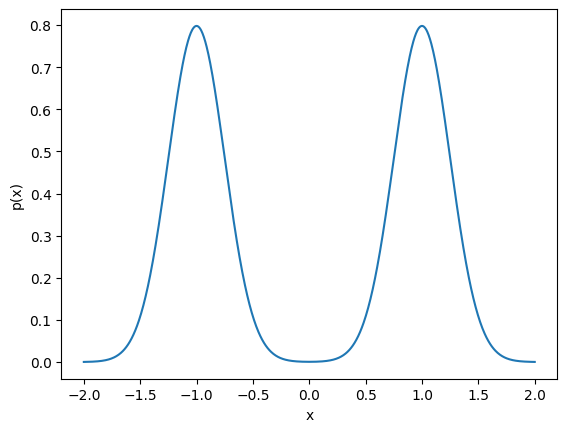

In [4]:
ax = plt.subplot()
ax.plot(x_plot, y)
ax.set_xlabel('x')
ax.set_ylabel('p(x)')

Now we proceed to drawing samples from the distribution. As it is a Gaussian distribution we can directly sample
from it using the build-in sampling methods from JAX. They are found in the `jax.random` namespace. This is
again very much like `numpy`, however there is an important difference: instead of a global `RandomState` object
JAX uses an approach, based on "keys", which can be split locally and are passed to the random sampling method:

In [5]:
n_samples_ = 500_000

key = random.key(9834)

# TBD: this assumes equal norm, draw from bernoull instead...
x_init = sigma * random.normal(key, (2, n_samples_ // 2,)) + mu

Let's make a histogram of the samples to verify the shape of the distribution:

Text(0, 0.5, '$p(x_i)$')

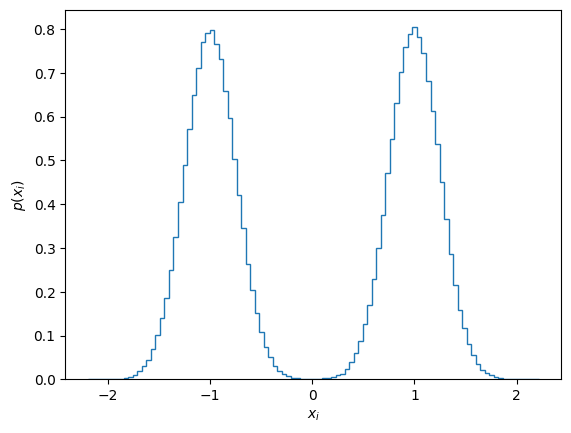

In [6]:
ax = plt.subplot()
ax.hist(x_init.flatten(), bins=100, density=True, histtype='step', label="Initial samples");
ax.set_xlabel('$x_i$')
ax.set_ylabel('$p(x_i)$')

Now we introduce the actual diffusion process. The diffusion process we choose here consists of two distinct steps / terms:

- **Diffusion**: add noise to the sample, by adding a Gaussian random variable with mean 0 and variance $\beta_t$, this corresponds to a random motion of the particle (think e.g. [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion))
- **Drift**: move current position of sample towards the origin, by multiplying with a constant factor $\sqrt{1 - \beta_t}$, this is equivalent to an external force acting on the particle.


In addition we assume $\beta_t \in [0, 1] $ and $\beta_t \to 1$ with time. With this specific choice of can achieve that the process finally converges towards a normal Gaussian distribution $\mathcal{N}(0, 1)$. The choice of the factors given above seems a bit "magic" here, but the reasoning is given in more detail in the DDPM paper I linked above (**hint:** in addition to leading to convergence to a unit Gaussian it also allows for computing the n-th time step in closed form, which will see later in the tutorial).

For now we can just numerically convince ourselves that this process indeed transforms our two component GMM into a normal Gaussian Distribution:

In [25]:
n_iter = 100
beta_t = jnp.linspace(0, 1, n_iter)
x = x_init.flatten()

sample_trace_diffusion_beta = []

for idx, beta in enumerate(beta_t):
    key, sub_key = random.split(key)
    x = jnp.sqrt(1. - beta) * x + beta * random.normal(key=sub_key, shape=x.shape)
    sample_trace_diffusion_beta.append(x)

sample_trace_diffusion_beta = jnp.stack(sample_trace_diffusion_beta, axis=0)

To visualize the process over time, we can make a histogram of the samples at each point in time `t`. Of course we can use a Python loop for this and call e.g. `np.histogram` and append all results, however this is a good time to introduce a first function transform in JAX, named `jax.vmap`. `jax.vmap` allows to map an arbitrary function over the leading dimension of an array. It is comparable to `np.vectorize`, however the latter basically implements a Python loop, while `jax.vmap` lowers the operation to compiled code and is thus much faster. 

So now we can use it to map `jnp.histogram` over the time dimension of our samples:

In [8]:
default_hist = partial(jnp.histogram, bins=100, range=(-3, 3), density=True)

batched_histogram = jax.vmap(default_hist)

For covenence we combined this into a little helper function, we can use to see hoe the density chamges with time and plot the trajectory of some example particles:

<Axes: xlabel='# Iteration', ylabel='x'>

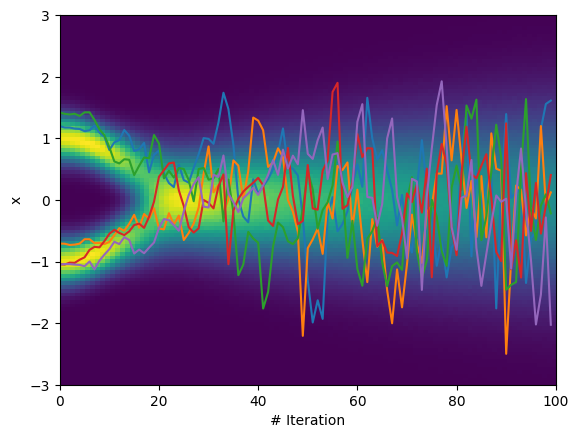

In [9]:
def plot_trace(trace, n_traces=5, ax=None, x_min=-3, x_max=3):
    """Plot distribution at multiple points in time as trace"""
    hist_values, _ = batched_histogram(trace)    

    n_iter, n_samples = trace.shape

    ax = plt.subplot() or ax
    ax.imshow(hist_values.T[:, :], extent=[0, n_iter, x_min, x_max], aspect="auto", origin="lower")

    # plot some example traces
    key = random.PRNGKey(9823)
    for idx in random.randint(key, (n_traces,), 0, n_samples):
        ax.plot(trace[:, idx])

    ax.set_ylim(x_min, x_max)
    ax.set_xlabel("# Iteration")
    ax.set_ylabel("x")
    return ax

plot_trace(sample_trace_diffusion_beta)

We can easily convince ourself, that the final (stationary) distribution is indeed a standard Gaussian:

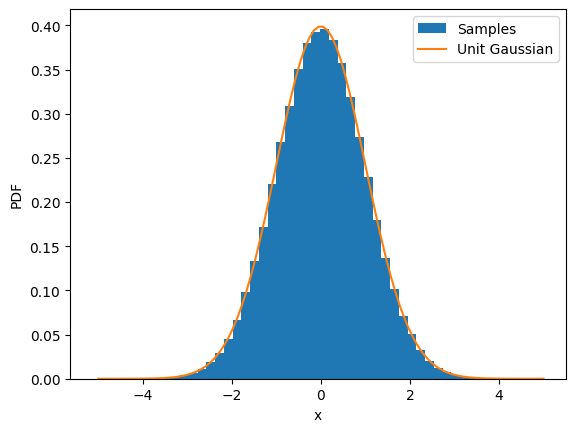

In [10]:
ax = plt.subplot()
ax.hist(sample_trace_diffusion_beta[-1], density=True, bins=50, label="Samples")

x_plot = jnp.linspace(-5, 5, 100)
ax.plot(x_plot, gaussian(x_plot, norm=1, mu=0, sigma=1), label="Unit Gaussian")
ax.set_xlabel("x")
ax.set_ylabel("PDF")
ax.legend()

## "Reversing" Diffusion via Langevin Dynamics

Now that we have "destroyed" our intial distribution (the two component Gaussian) with the forward diffusion process, wouldn't it be great if we could reverse the process? This would give us a sampling algorithm, that allowed us to sample from an arbitrary distribution. Starting from a normal Gaussian distribution we would transform the samples back into the shape of the intial distribution.

It turns out such an algorithm exists, it is named ["Langevin Dynamics"](https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics). However the algorithm requires one additional piece of information: the score function of the target distribution. The score function is defined as the gradient of the log of the distribution.

In JAX we can directly get the score function by taking the gradient of the log using `jax.grad()`:

In [42]:
def log_gmm(x, norm, mu, sigma):
    """Log of the GMM"""
    return jnp.log(gmm(x, norm, mu, sigma))

gmm_log_part = partial(log_gmm, norm=norm, mu=mu, sigma=sigma) # the partial just simplifies not parsing the parameters later...
score_fun = jax.vmap(jax.grad(gmm_log_part))

Now we can see what it looks like:

Text(0, 0.5, 'd/dx log p(x)')

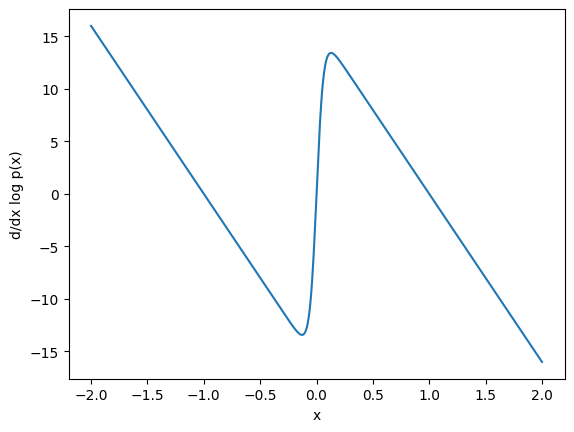

In [43]:
ax = plt.subplot()
x_plot = jnp.linspace(-2, 2, 1000)
ax.plot(x_plot, score_fun(x_plot))
ax.set_xlabel('x')
ax.set_ylabel('d/dx log p(x)')

Now let us implement a reverse diffusion process based on "Langevin Dynamics". Starting from an initial sample $x_i$, the algorithm looks like this:

$\begin{align} \mathbf{x}_{i+1} \gets \mathbf{x}_i + \alpha \nabla_\mathbf{x} \log p(\mathbf{x}) + \sqrt{2\alpha}~ \mathbf{z}_i, \quad i=0,1,\cdots, K, \end{align}$

Where $\mathbf{z}_i \sim \mathcal{N}(0, I)$. When $\alpha \to 0$ and $K \to \infty$, this converges to the target distribution, defined by its score function $\nabla_\mathbf{x} \log p(\mathbf{x})$.

While we could implement the algorithm the same way we did above using a Python loop, we make use of another JAX fundemantal, named [`jax.lax.scan`](https://docs.jax.dev/en/latest/_autosummary/jax.lax.scan.html). `lax.scan` allows you scan a function over the leading array axes while carrying along a state. It requires us to defined the "body" of the loop in a dedicated function:


In [44]:
# JAX can natively handle "structs of arrays" or "PyTrees"
SampleArgs = namedtuple("Args", ["key", "idx", "x", "alpha_0", "p_0"])

def sample(score, args, _):
    # compute the "learning rate" depending on the iteration
    alpha = args.alpha_0 * (args.p_0 ** args.idx) ** 2

    # sample stochastic update
    key, subkey = random.split(args.key)
    dx = random.normal(subkey, args.x.shape)

    # combine the gradient and the stochastic update
    x = args.x + 0.5 * alpha * score(args.x) + jnp.sqrt(alpha) * dx
    return SampleArgs(key, args.idx + 1, x, args.alpha_0, args.p_0), x

Now we can use that function by defining the initial state first and calling `jax.lax.scan`:

In [45]:
n_samples = 100_000
n_iter = 500

key = random.PRNGKey(42)
key, subkey = random.split(key)

init = SampleArgs(
    key=key,
    idx=0,
    x=random.normal(subkey, (n_samples,)),
    alpha_0=0.002,
    p_0=1.0
)

result, sample_trace = jax.lax.scan(partial(sample, score_fun), init, length=n_iter)

<Axes: xlabel='# Iteration', ylabel='x'>

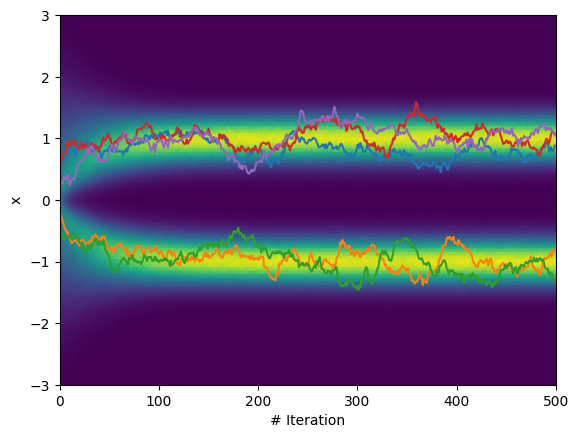

In [46]:
plot_trace(sample_trace)

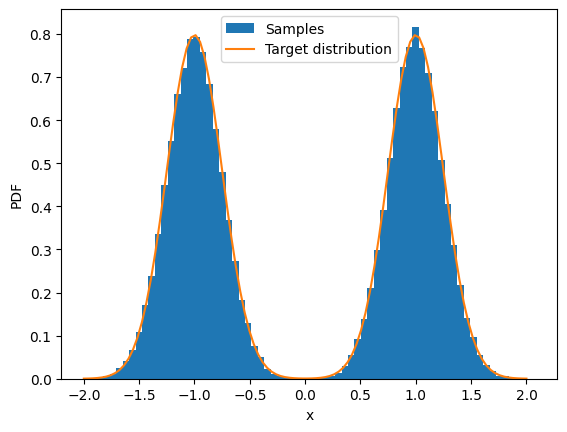

In [47]:
ax = plt.subplot()
ax.hist(sample_trace[-1], density=True, bins=70, label="Samples")

x_plot = jnp.linspace(-2, 2, 100)
y = gmm(x_plot, norm, mu, sigma)
ax.plot(x_plot, y, label="Target distribution")
ax.set_xlim()
ax.set_xlabel("x")
ax.set_ylabel("PDF")
ax.legend()

So we have transformed the samples from a unit Gaussian into the target distribution using Langevin dynamics!

## Score Matching
In this next section we will go from the simple Langevin dynamics example to Denoising Diffusion Probabilistic Models (DDPM) [Ho et al](https://arxiv.org/abs/2006.11239).
The Langevin dynamics example required the knowledge of the score function, which we derived from the bimodal Gaussian 
PDF using `jax.grad`.

However in general we do not have access to the score function, we just have access to the data distribution. Still we can estimate the score function from the data in a process called "score matching", introduced by [Hyvarinen, 2005](https://jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf). It is intuitive that to "match the score" we could minimize the expectation value of the squared difference between a model function $\mathcal{F}_{\theta}(\mathbf{x})$ and the score function computed from the data distribution (leaving open how to do this for now):

$$\mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right]$$

The core of the method of "score matching" involves the intesting result, that the MSE loss between the score function and the gradient of the log PDF can be reformulated as:

$$\mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]$$

If you are interested in the mathematical derivation of this new loss, you can checkout e.g. http://yang-song.net/blog/2019/ssm/